# Cyber Bullying Detection

### Dataset Loading and Label Assignment

In [1]:
import os
import pandas as pd

DATASET_PATH ="data"

texts=[]
labels=[]

file_to_label ={
    "8000age.txt": "age",
    "8000ethnicity.txt": "ethnicity",
    "8000gender.txt": "gender",
    "8000religion.txt": "religion",
    "8000other.txt": "general_harassment",
    "8000notcb.txt": "not_cyberbullying"
}

for filename, label in file_to_label.items():
    file_path=os.path.join(DATASET_PATH, filename)

    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            text = line.strip()
            if text:
                texts.append(text)
                labels.append(label)

# Create DataFrame
df = pd.DataFrame({
    "text": texts,
    "label": labels
})

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (47998, 2)


,text,label
0,Here at home. Neighbors pick on my family and ...,age
1,Being bullied at school: High-achieving boys u...,age
2,There was a girl in my class in 6th grade who ...,age
3,He’s probably a white gay kid from some suburb...,age
4,You are pushed ti resorting. Treating thr bull...,age


## Data Understanding

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47998 entries, 0 to 47997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47998 non-null  object
 1   label   47998 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB


In [3]:
# to check missing values
df.isnull().sum()

text     0
label    0
dtype: int64

In [4]:
df['label'].value_counts()

label
ethnicity             8000
gender                8000
not_cyberbullying     8000
religion              8000
age                   7999
general_harassment    7999
Name: count, dtype: int64

In [5]:
df.describe()

,text,label
count,47998,47998
unique,46321,6
top,@wiemanindenwald Sooooo true.,ethnicity
freq,2,8000


## Dataset Visualization

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\1859747328.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


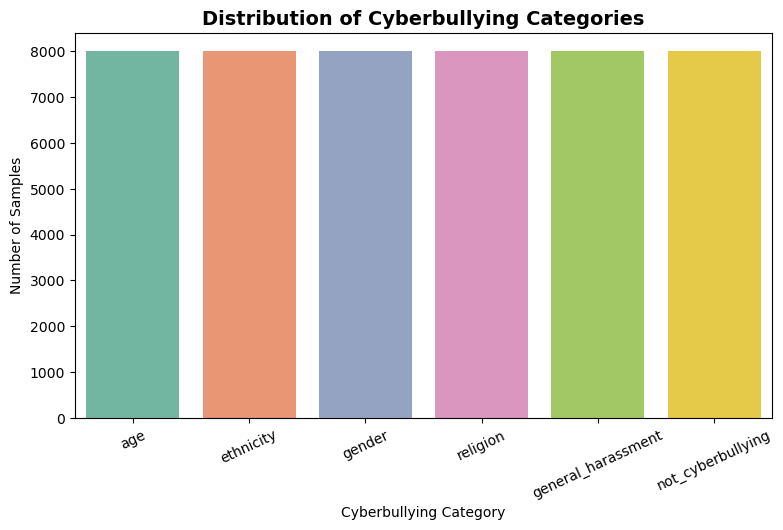

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))
sns.countplot(
    data=df,
    x="label",
    palette="Set2" 
)

plt.title("Distribution of Cyberbullying Categories", fontsize=14, fontweight="bold")
plt.xlabel("Cyberbullying Category")
plt.ylabel("Number of Samples")
plt.xticks(rotation=25)
plt.show()

In [7]:
df['text'].sample(5)

45478    Just discovered what happens when jeans are to...
24113    RT @RavenHUWolf: #Austin #Texas Muslims assume...
12953    Why are you mad Fat Girl RT @tayyoung_: FUCK O...
18738    Oh nah I don’t condone jokes about rape, DV or...
34459    RT @stibbons: @freebsdgirl bahah google sugges...
Name: text, dtype: object

In [8]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

df['word_count'].describe()

count    47998.000000
mean        23.559377
std         14.129385
min          1.000000
25%         13.000000
50%         20.000000
75%         32.000000
max         65.000000
Name: word_count, dtype: float64

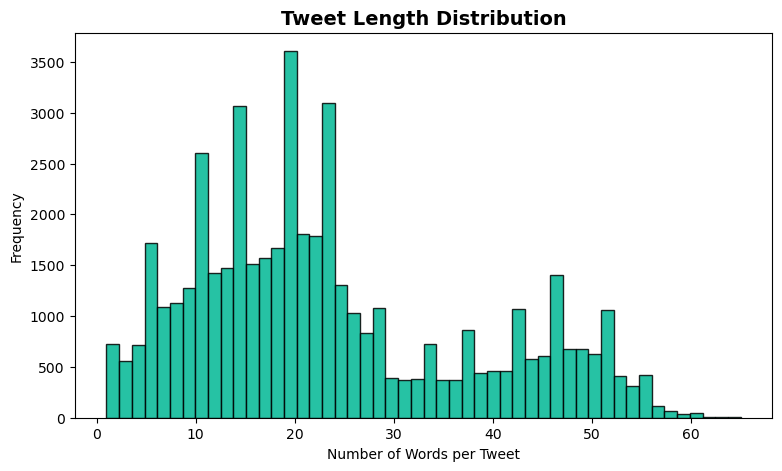

In [9]:
plt.figure(figsize=(9,5))
plt.hist(
    df['word_count'],
    bins=50,
    color="#00b894",   # modern green
    edgecolor="black",
    alpha=0.85
)

plt.title("Tweet Length Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Frequency")
plt.show()


## Data Preparation

In [10]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Cleaning & Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Remove HTML tags 
    text = re.sub(r"<.*?>", "", text)
    
    # Remove punctuation & numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords & lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join back to string
    return " ".join(tokens)

In [12]:
df['clean_text'] = df['text'].apply(preprocess_text)

In [13]:
df[['text', 'clean_text']].sample(5)

,text,clean_text
31276,What happened in Gujarat was retaliation & tho...,happened gujarat retaliation started riot dese...
20557,"twitch chat aka ""an amassment of dudes making ...",twitch chat aka amassment dude making joke rap...
13847,You missed the point of the tweet I never said...,missed point tweet never said people couldnt g...
10814,Bryce is dumb as fuck I swear. Btw why did you...,bryce dumb fuck swear btw call nigger
29273,Well then why did Brazile think she had to rig...,well brazile think right comment republican ra...


### Train-Test Split

In [14]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### TF-IDF VECTORIZE

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,   # keeps top 5000 terms
    ngram_range=(1,2)    # unigrams + bigrams
)

# Fit on TRAIN only
X_train = tfidf.fit_transform(X_train_text)

# Transform TEST
X_test = tfidf.transform(X_test_text)

In [16]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (38398, 5000)
X_test shape: (9600, 5000)


## LOGISTIC REGRESSION TRAINING & EVALUATION

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
log_reg = LogisticRegression(
    max_iter=1000,       # ensure convergence
    random_state=42,
    C=1.0,               # regularization strength
    solver='liblinear'   # multi-class support
)

# Fit model
log_reg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [38]:
y_pred = log_reg.predict(X_test)

#### Accuracy Evaluation

In [39]:
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", round(accuracy*100, 2), "%")

Logistic Regression Accuracy: 83.52 %


#### Classification Report

In [21]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

               age       0.94      0.97      0.95      1600
         ethnicity       0.98      0.97      0.97      1600
            gender       0.91      0.85      0.88      1600
general_harassment       0.62      0.75      0.68      1600
 not_cyberbullying       0.64      0.51      0.56      1600
          religion       0.95      0.95      0.95      1600

          accuracy                           0.84      9600
         macro avg       0.84      0.84      0.83      9600
      weighted avg       0.84      0.84      0.83      9600



#### Confusion Matrix

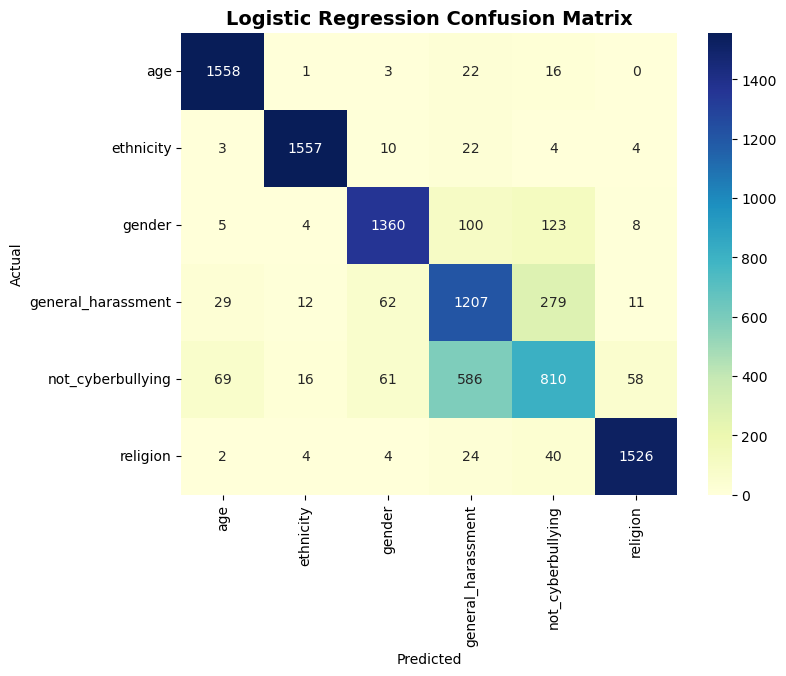

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=log_reg.classes_,
    yticklabels=log_reg.classes_
)
plt.title("Logistic Regression Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Error Analysis

In [25]:
import pandas as pd

# Create a DataFrame for errors
errors = pd.DataFrame({
    "text": X_test_text.values,
    "true_label": y_test.values,
    "predicted_label": y_pred
})

# Filter misclassified rows
misclassified = errors[errors['true_label'] != errors['predicted_label']]
misclassified.sample(5)

,text,true_label,predicted_label
8971,animecommentary count im pretty snarky serious...,not_cyberbullying,general_harassment
3485,feminazis sink claw lewinsky sexy tellall tcot...,gender,not_cyberbullying
5694,another day fucking paradise fella thing hear ...,general_harassment,not_cyberbullying
3900,andykhouri mad prop comicsalliance well done,general_harassment,not_cyberbullying
2648,albertinho cant tell sarcasm clueless,general_harassment,not_cyberbullying


### Visualizing Word Importance per class

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\2287246874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")


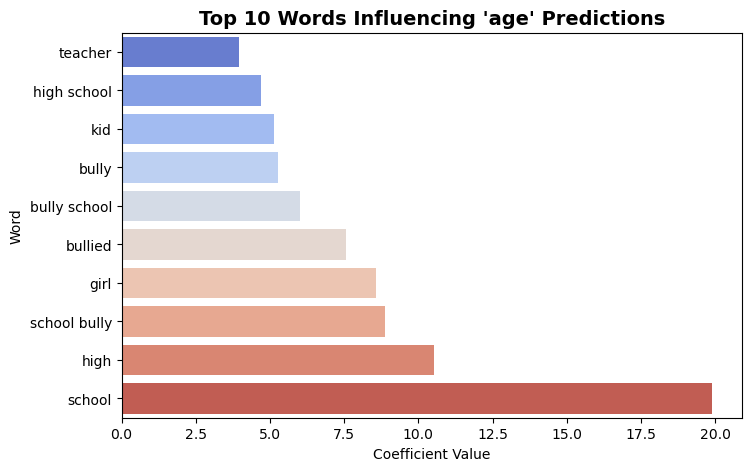

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\2287246874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")


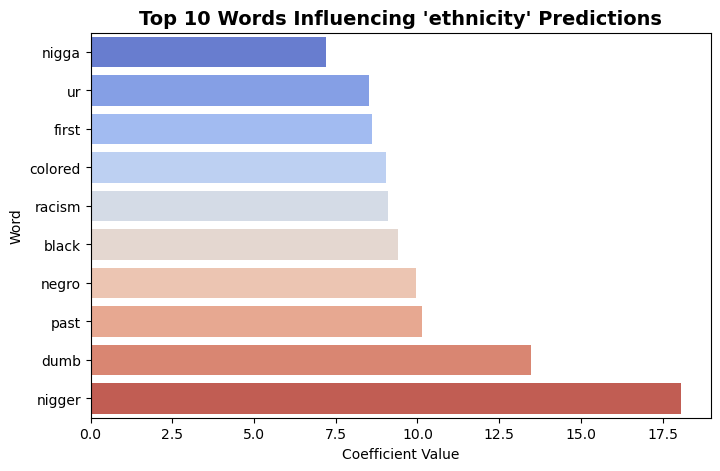

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\2287246874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")


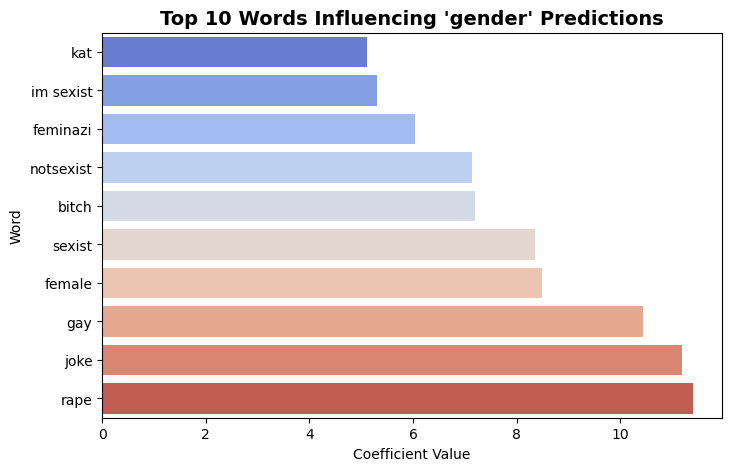

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\2287246874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")


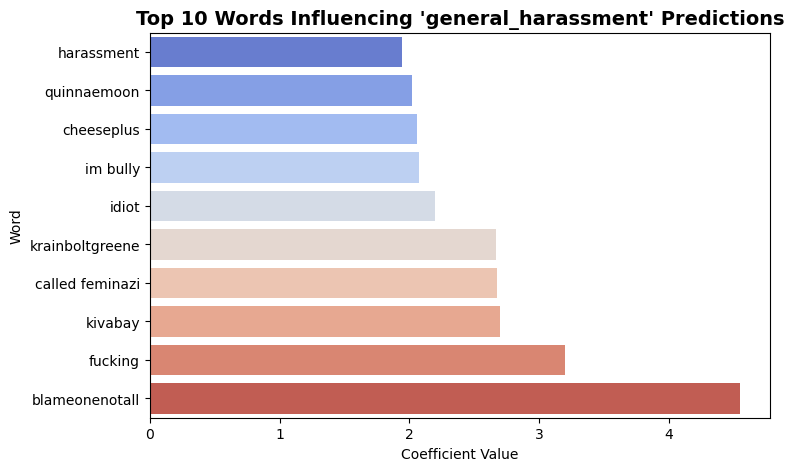

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\2287246874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")


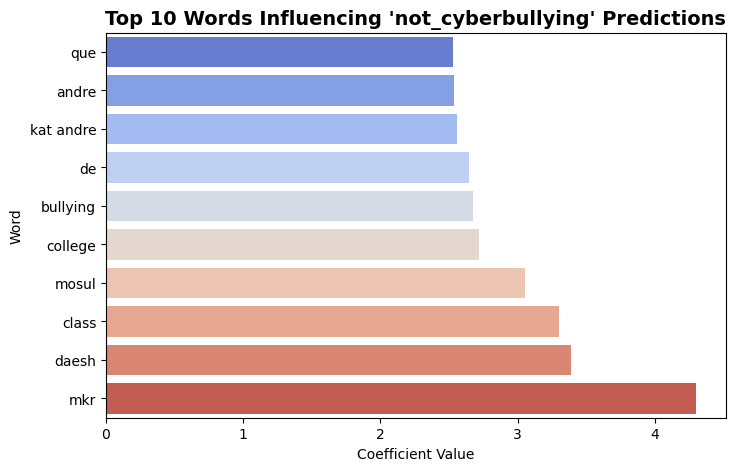

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\2287246874.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")


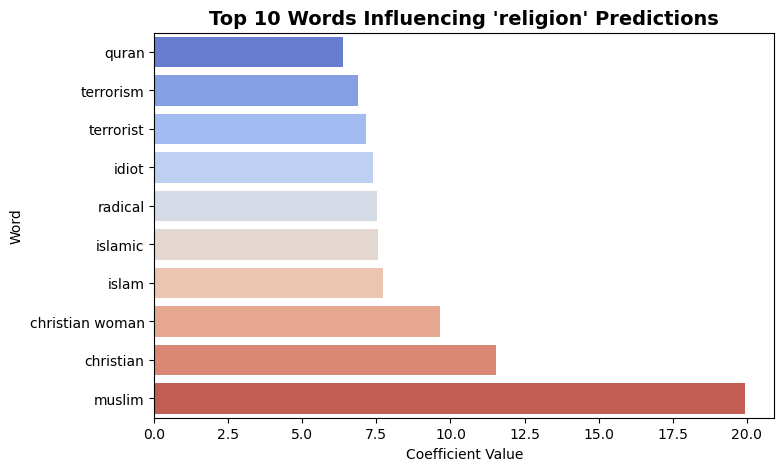

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = tfidf.get_feature_names_out()

for class_label in log_reg.classes_:
    class_index = list(log_reg.classes_).index(class_label)
    coefficients = log_reg.coef_[class_index]
    
    # Get top 10 positive features
    top10_idx = np.argsort(coefficients)[-10:]
    top_features = feature_names[top10_idx]
    top_coeffs = coefficients[top10_idx]
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_coeffs, y=top_features, palette="coolwarm")
    plt.title(f"Top 10 Words Influencing '{class_label}' Predictions", fontsize=14, fontweight="bold")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Word")
    plt.show()

## Multinomial Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [41]:
nb_model = MultinomialNB()

# Fit on training data
nb_model.fit(X_train, y_train)

MultinomialNB()

In [42]:
y_pred_nb = nb_model.predict(X_test)

#### Accuracy Evaluation

In [43]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", round(accuracy_nb*100,2), "%")

Naive Bayes Accuracy: 78.59 %


#### Classification Report

In [44]:
print(classification_report(y_test, y_pred_nb))

                    precision    recall  f1-score   support

               age       0.84      0.96      0.90      1600
         ethnicity       0.85      0.92      0.88      1600
            gender       0.87      0.80      0.84      1600
general_harassment       0.62      0.62      0.62      1600
 not_cyberbullying       0.65      0.44      0.53      1600
          religion       0.83      0.96      0.89      1600

          accuracy                           0.79      9600
         macro avg       0.78      0.79      0.78      9600
      weighted avg       0.78      0.79      0.78      9600



#### Confusion Matrix

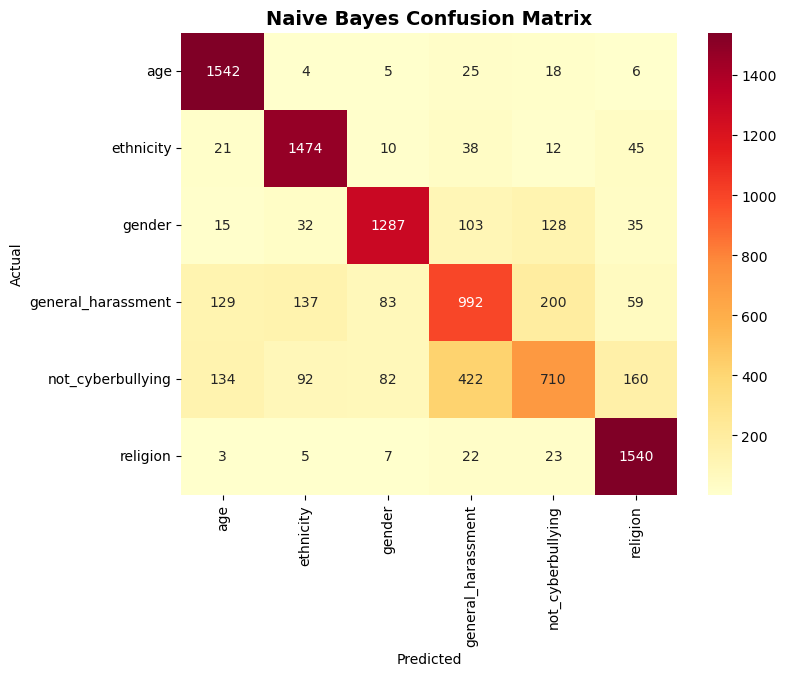

In [45]:
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=nb_model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    xticklabels=nb_model.classes_,
    yticklabels=nb_model.classes_
)
plt.title("Naive Bayes Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Visualization of Top Words per class for Naive Bayes

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\831070633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette="magma")


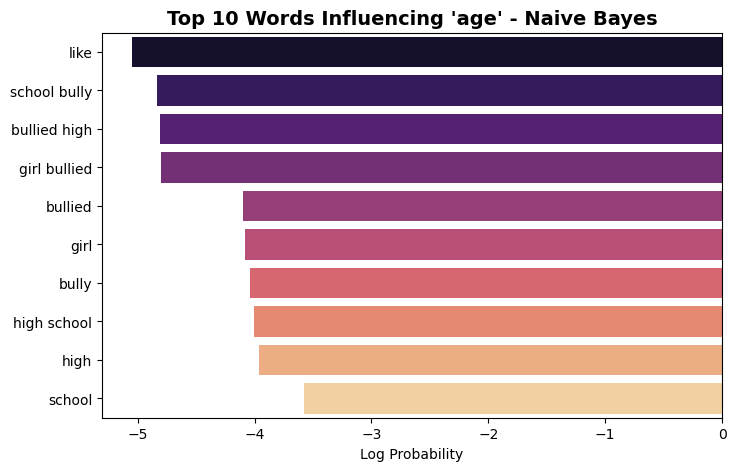

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\831070633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette="magma")


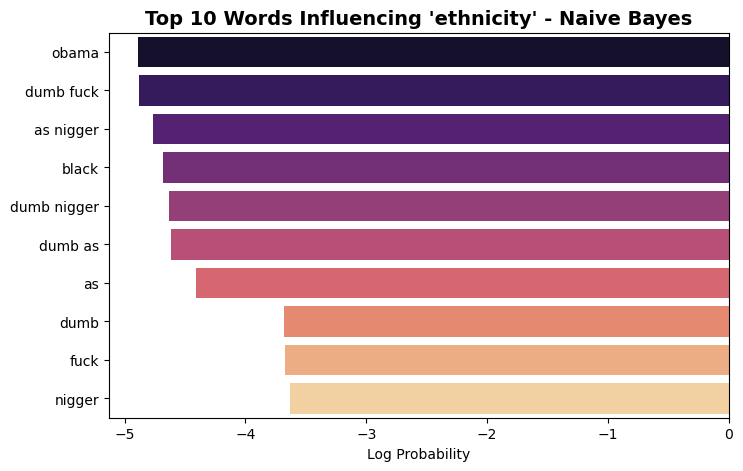

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\831070633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette="magma")


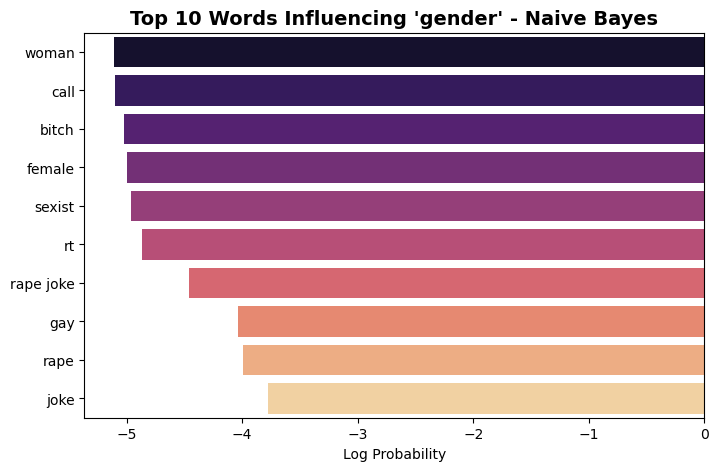

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\831070633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette="magma")


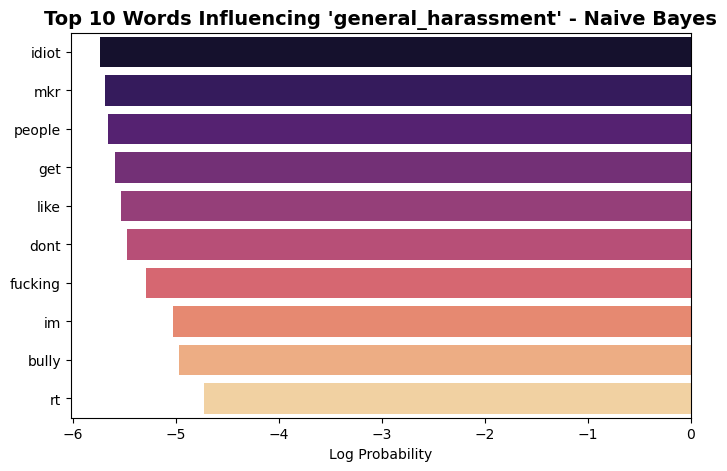

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\831070633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette="magma")


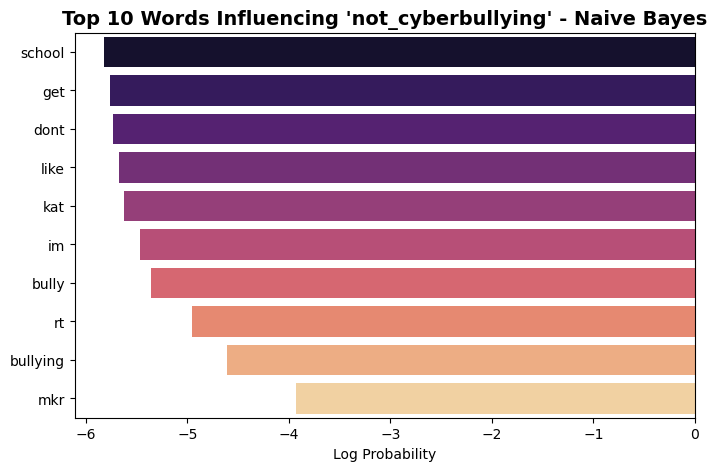

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\831070633.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette="magma")


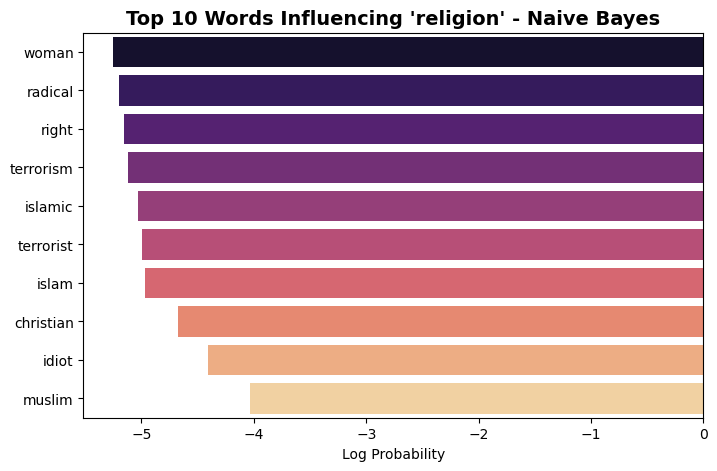

In [46]:
feature_names = tfidf.get_feature_names_out()

for class_index, class_label in enumerate(nb_model.classes_):
    # Get top 10 words
    top10_idx = nb_model.feature_log_prob_[class_index].argsort()[-10:]
    top_features = feature_names[top10_idx]
    top_probs = nb_model.feature_log_prob_[class_index][top10_idx]

    plt.figure(figsize=(8,5))
    sns.barplot(x=top_probs, y=top_features, palette="magma")
    plt.title(f"Top 10 Words Influencing '{class_label}' - Naive Bayes", fontsize=14, fontweight="bold")
    plt.xlabel("Log Probability")
    plt.show()

#### Error Analysis

In [47]:
errors_nb = pd.DataFrame({
    "text": X_test_text.values,
    "true_label": y_test.values,
    "predicted_label": y_pred_nb
})

misclassified_nb = errors_nb[errors_nb['true_label'] != errors_nb['predicted_label']]
misclassified_nb.sample(5)

,text,true_label,predicted_label
6975,kat amazing future mkr think role wicked step ...,gender,not_cyberbullying
8802,billboardchart suahshuasuah lady gaga sofrendo...,general_harassment,not_cyberbullying
8931,bitch practically bullied going tonight good t...,not_cyberbullying,general_harassment
7776,ricedee change brah sent way,not_cyberbullying,general_harassment
2008,ok guess using screenshots lol legit messaged ...,ethnicity,general_harassment


## Linear SVM

In [48]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize
svm_model = LinearSVC(
    max_iter=5000,   # ensure convergence
    random_state=42
)

# Train
svm_model.fit(X_train, y_train)

LinearSVC(max_iter=5000, random_state=42)

In [49]:
y_pred_svm = svm_model.predict(X_test)

#### Accuracy Evaluation

In [50]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Linear SVM Accuracy:", round(accuracy_svm*100,2), "%")

Linear SVM Accuracy: 82.81 %


#### Classification Report

In [52]:
print(classification_report(y_test, y_pred_svm))

                    precision    recall  f1-score   support

               age       0.96      0.97      0.96      1600
         ethnicity       0.98      0.97      0.98      1600
            gender       0.88      0.85      0.87      1600
general_harassment       0.61      0.71      0.65      1600
 not_cyberbullying       0.60      0.51      0.55      1600
          religion       0.95      0.95      0.95      1600

          accuracy                           0.83      9600
         macro avg       0.83      0.83      0.83      9600
      weighted avg       0.83      0.83      0.83      9600



#### Confusion Matrix 

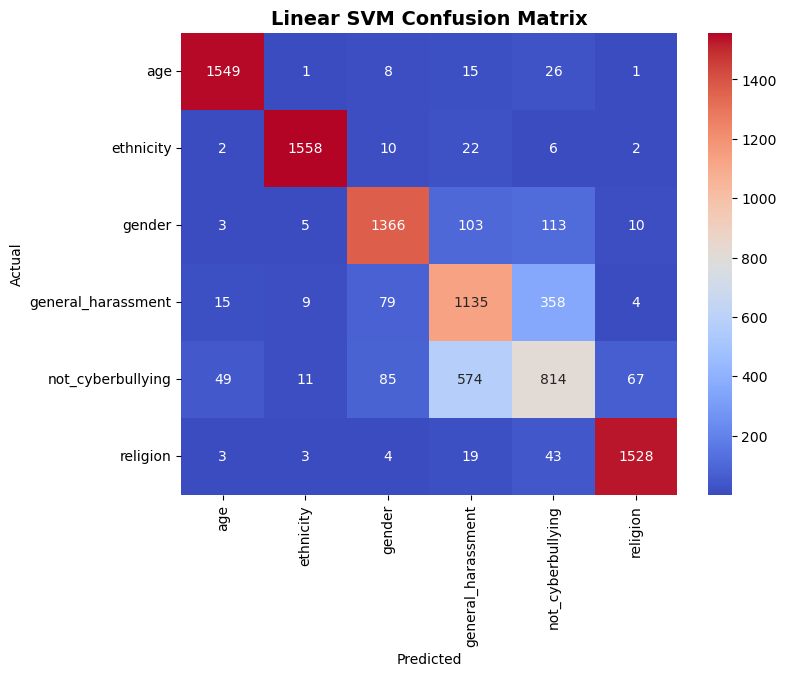

In [53]:
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=svm_model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt="d",
    cmap="coolwarm",
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.title("Linear SVM Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Top Words Per Class for Linear SVM 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\955400474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\955400474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\955400474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\955400474.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` 

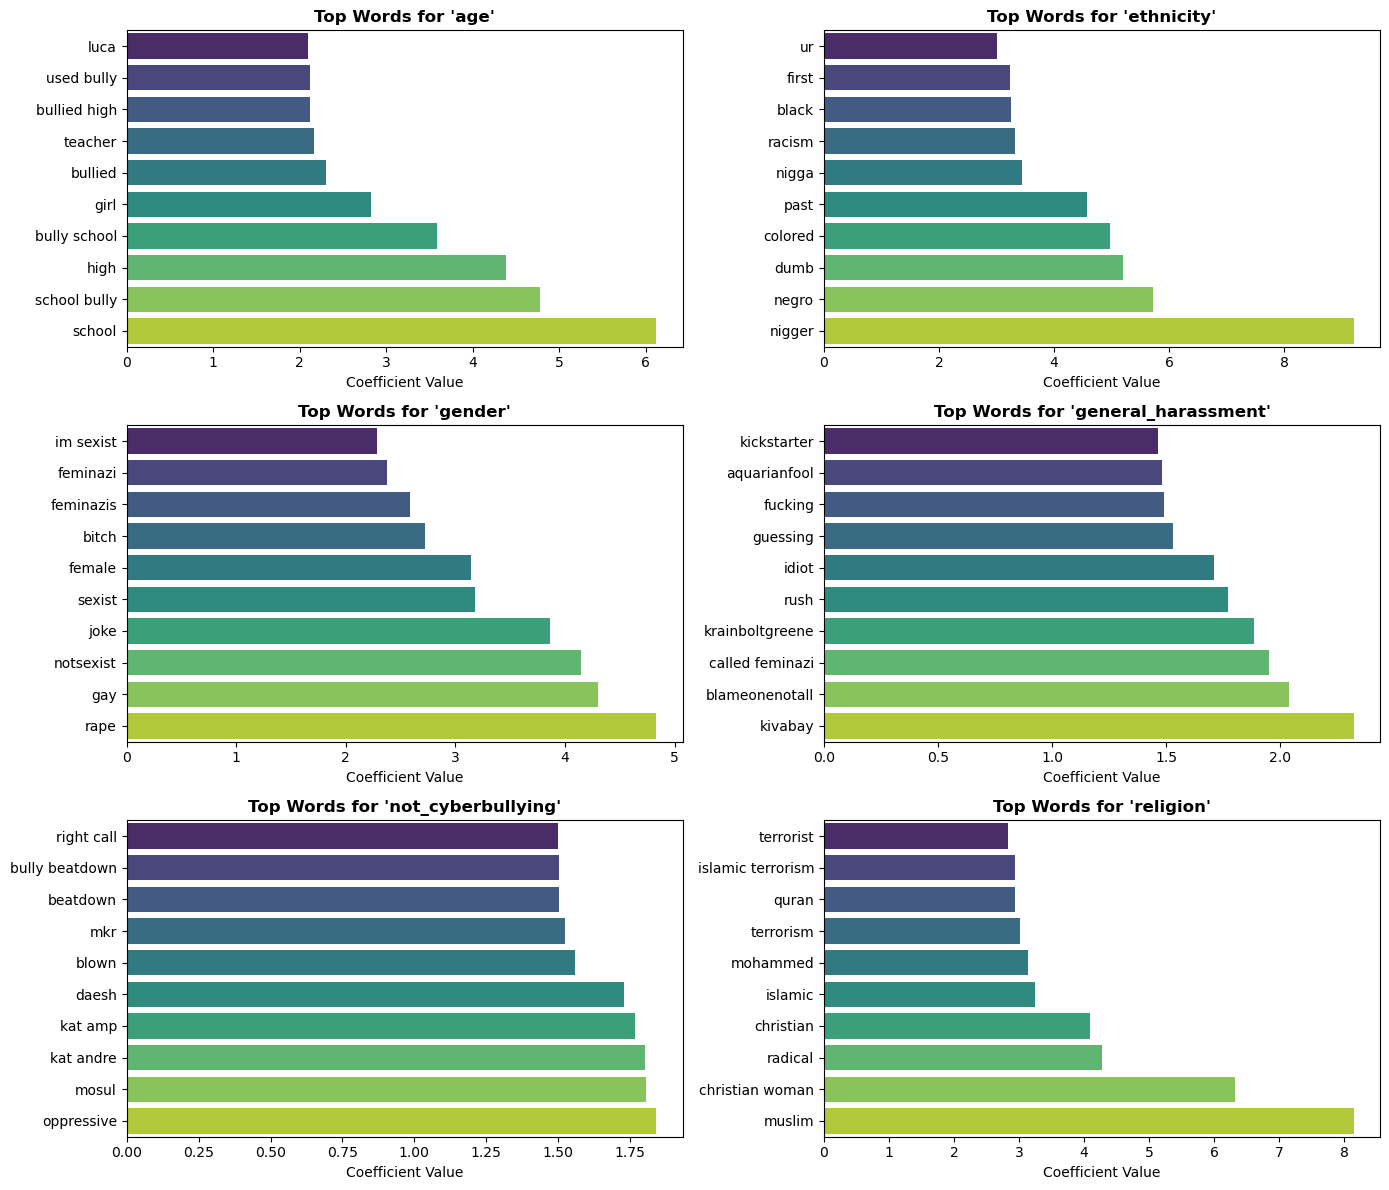

In [57]:
import math

feature_names = tfidf.get_feature_names_out()
num_classes = len(svm_model.classes_)
cols = 2
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows*4))
axes = axes.flatten()

for i, class_label in enumerate(svm_model.classes_):
    class_index = i
    coefficients = svm_model.coef_[class_index]
    
    top10_idx = np.argsort(coefficients)[-10:]
    top_features = feature_names[top10_idx]
    top_coeffs = coefficients[top10_idx]
    
    sns.barplot(
        x=top_coeffs, y=top_features, ax=axes[i], palette="viridis"
    )
    axes[i].set_title(f"Top Words for '{class_label}'", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Coefficient Value")
    axes[i].set_ylabel("")

# Remove empty subplot if classes < rows*cols
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Ensemble Learning: Hard Voting

In [61]:
from sklearn.ensemble import VotingClassifier

#3 models for hard voting
hard_voting = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('nb', nb_model),
        ('svm', svm_model)
    ],
    voting='hard'  # majority vote
)


In [62]:
# Training
hard_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='liblinear')),
                             ('nb', MultinomialNB()),
                             ('svm',
                              LinearSVC(max_iter=5000, random_state=42))])

In [63]:
# Predicting
y_pred_hard = hard_voting.predict(X_test)

#### Accuracy Evaluation 

In [64]:
# Accuracy
from sklearn.metrics import accuracy_score, classification_report

print("Hard Voting Accuracy:", round(accuracy_score(y_test, y_pred_hard)*100,2), "%")

Hard Voting Accuracy: 83.17 %


#### Classification Report

In [59]:
print(classification_report(y_test, y_pred_hard))

                    precision    recall  f1-score   support

               age       0.91      0.98      0.94      1600
         ethnicity       0.97      0.97      0.97      1600
            gender       0.89      0.85      0.87      1600
general_harassment       0.62      0.73      0.67      1600
 not_cyberbullying       0.64      0.49      0.56      1600
          religion       0.94      0.96      0.95      1600

          accuracy                           0.83      9600
         macro avg       0.83      0.83      0.83      9600
      weighted avg       0.83      0.83      0.83      9600



### Ensemble Learning: Soft Voting

In [65]:
soft_voting = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('nb', nb_model)
    ],
    voting='soft',  # weighted probabilities
    weights=[1,1]   # weighting models
)

In [66]:
soft_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(max_iter=1000, random_state=42,
                                                 solver='liblinear')),
                             ('nb', MultinomialNB())],
                 voting='soft', weights=[1, 1])

In [67]:
y_pred_soft = soft_voting.predict(X_test)

#### Accuracy Evaluation

In [68]:
print("Soft Voting Accuracy:", round(accuracy_score(y_test, y_pred_soft)*100,2), "%")

Soft Voting Accuracy: 83.16 %


#### Classification Report

In [69]:
print(classification_report(y_test, y_pred_soft))

                    precision    recall  f1-score   support

               age       0.92      0.97      0.94      1600
         ethnicity       0.97      0.97      0.97      1600
            gender       0.91      0.83      0.87      1600
general_harassment       0.62      0.74      0.68      1600
 not_cyberbullying       0.64      0.50      0.56      1600
          religion       0.92      0.97      0.94      1600

          accuracy                           0.83      9600
         macro avg       0.83      0.83      0.83      9600
      weighted avg       0.83      0.83      0.83      9600



#### Confusion Matrix 

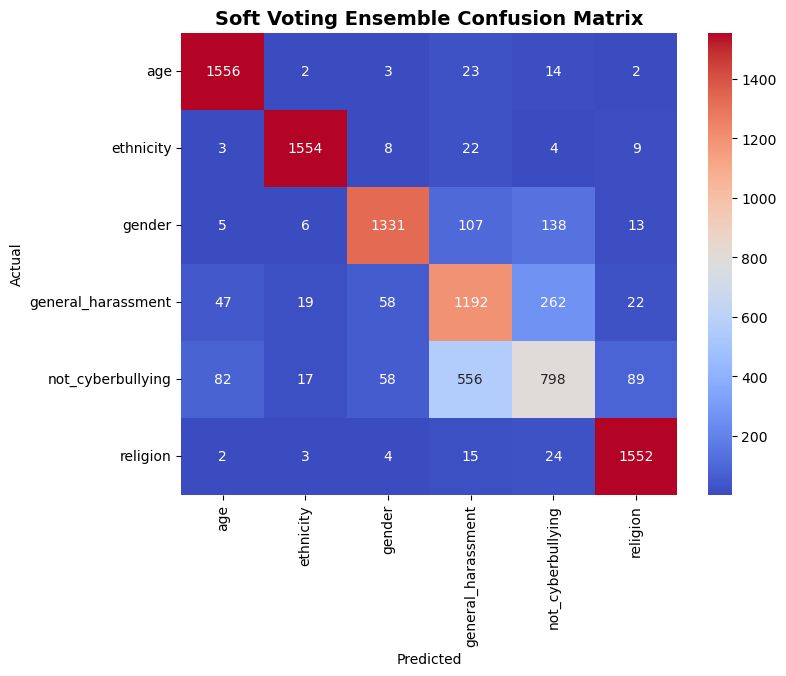

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_soft, labels=soft_voting.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=soft_voting.classes_,
            yticklabels=soft_voting.classes_)
plt.title("Soft Voting Ensemble Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Comparison of all Models

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\697907531.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=[a*100 for a in accuracies], palette="Set2")


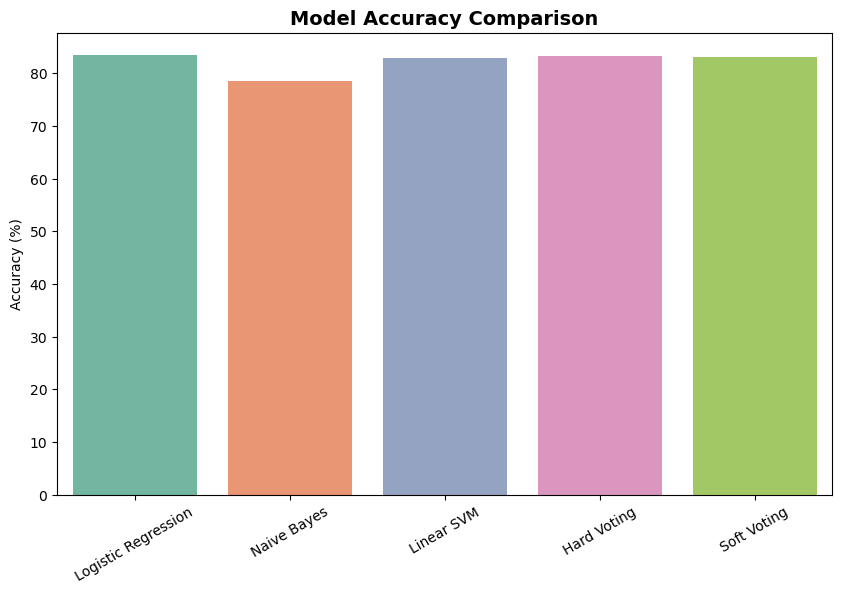

In [71]:
model_names = ['Logistic Regression', 'Naive Bayes', 'Linear SVM', 'Hard Voting', 'Soft Voting']
accuracies = [
    accuracy_score(y_test, y_pred),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_hard),
    accuracy_score(y_test, y_pred_soft)
]

plt.figure(figsize=(10,6))
sns.barplot(x=model_names, y=[a*100 for a in accuracies], palette="Set2")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison", fontsize=14, fontweight="bold")
plt.xticks(rotation=30)
plt.show()


In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# List of models and their predictions
models = {
    "Logistic Regression": y_pred,
    "Naive Bayes": y_pred_nb,
    "Linear SVM": y_pred_svm,
    "Hard Voting": y_pred_hard,
    "Soft Voting": y_pred_soft
}

# Initialize performance dataframe
performance = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

# Loop through models
for model_name, y_pred_model in models.items():
    acc = accuracy_score(y_test, y_pred_model)
    prec = precision_score(y_test, y_pred_model, average='weighted')
    rec = recall_score(y_test, y_pred_model, average='weighted')
    f1 = f1_score(y_test, y_pred_model, average='weighted')
    
    performance = pd.concat([
        performance,
        pd.DataFrame({
            "Model": [model_name],
            "Accuracy": [round(acc*100,2)],
            "Precision": [round(prec,2)],
            "Recall": [round(rec,2)],
            "F1-Score": [round(f1,2)]
        })
    ], ignore_index=True)

# Display performance comparison
performance

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\1752084430.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,83.52,0.84,0.84,0.83
1,Naive Bayes,78.59,0.78,0.79,0.78
2,Linear SVM,82.81,0.83,0.83,0.83
3,Hard Voting,83.17,0.83,0.83,0.83
4,Soft Voting,83.16,0.83,0.83,0.83


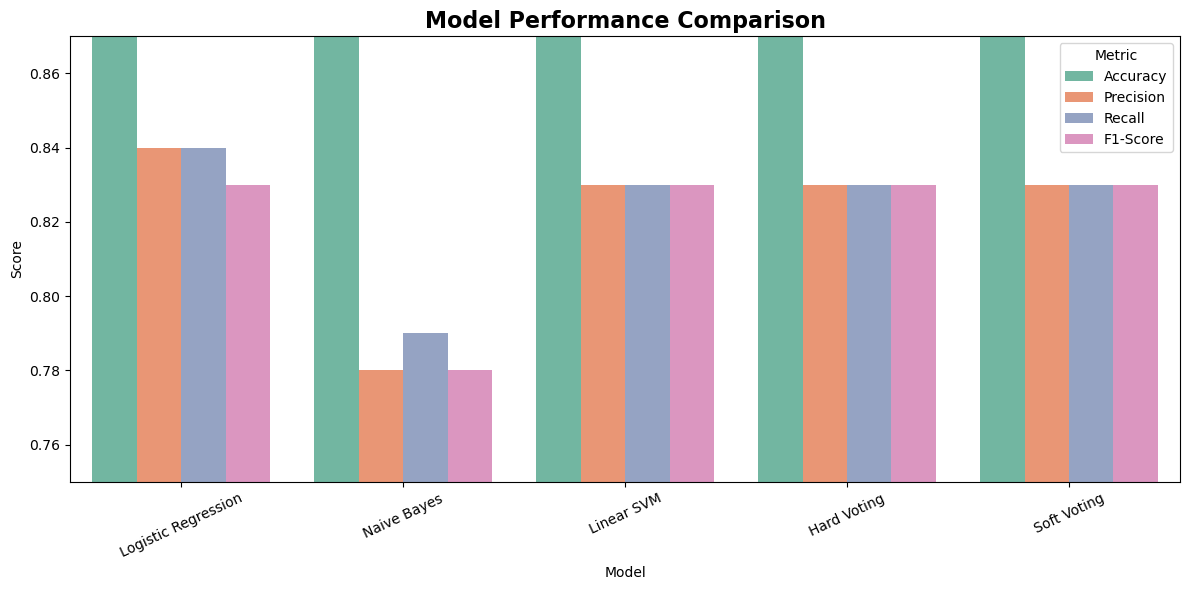

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Melt dataframe to long format for seaborn
perf_long = performance.melt(id_vars='Model', 
                             value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                             var_name='Metric', value_name='Score')

plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Score', hue='Metric', data=perf_long, palette="Set2")

plt.title("Model Performance Comparison", fontsize=16, fontweight="bold")
plt.ylabel("Score")
plt.ylim(0.75, 0.87)  
plt.xticks(rotation=25)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


In [81]:
def predict_category(text, model=log_reg, vectorizer=tfidf):
    """
    Predict cyberbullying category for a given text.

    Parameters:
    - text: str, input text
    - model: Logistic Regression
    - vectorizer: TF-IDF vectorizer used to train the model

    Returns:
    - pred_label: predicted category
    - confidence: probability of predicted category 
    """
    # Clean text (same preprocessing as training)
    processed = preprocess_text(text)
    
    # Transform using TF-IDF
    vectorized = vectorizer.transform([processed])
    
    # Predict label
    pred_label = model.predict(vectorized)[0]
    
    # Predict confidence
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(vectorized)[0]
        confidence = probs.max()
    else:
        confidence = None  
    
    return pred_label, confidence

In [82]:
sample_text = "I hate you black muslim abdul and you are terrible"

label, conf = predict_category(sample_text)

print("Predicted Category:", label)
if conf:
    print("Confidence:", round(conf*100,2), "%")
else:
    print("Confidence not available for this model")


Predicted Category: religion
Confidence: 86.07 %


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\264411542.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals, y=top_features, ax=ax, palette="viridis")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\264411542.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals, y=top_features, ax=ax, palette="viridis")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\264411542.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vals, y=top_features, ax=ax, palette="viridis")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9

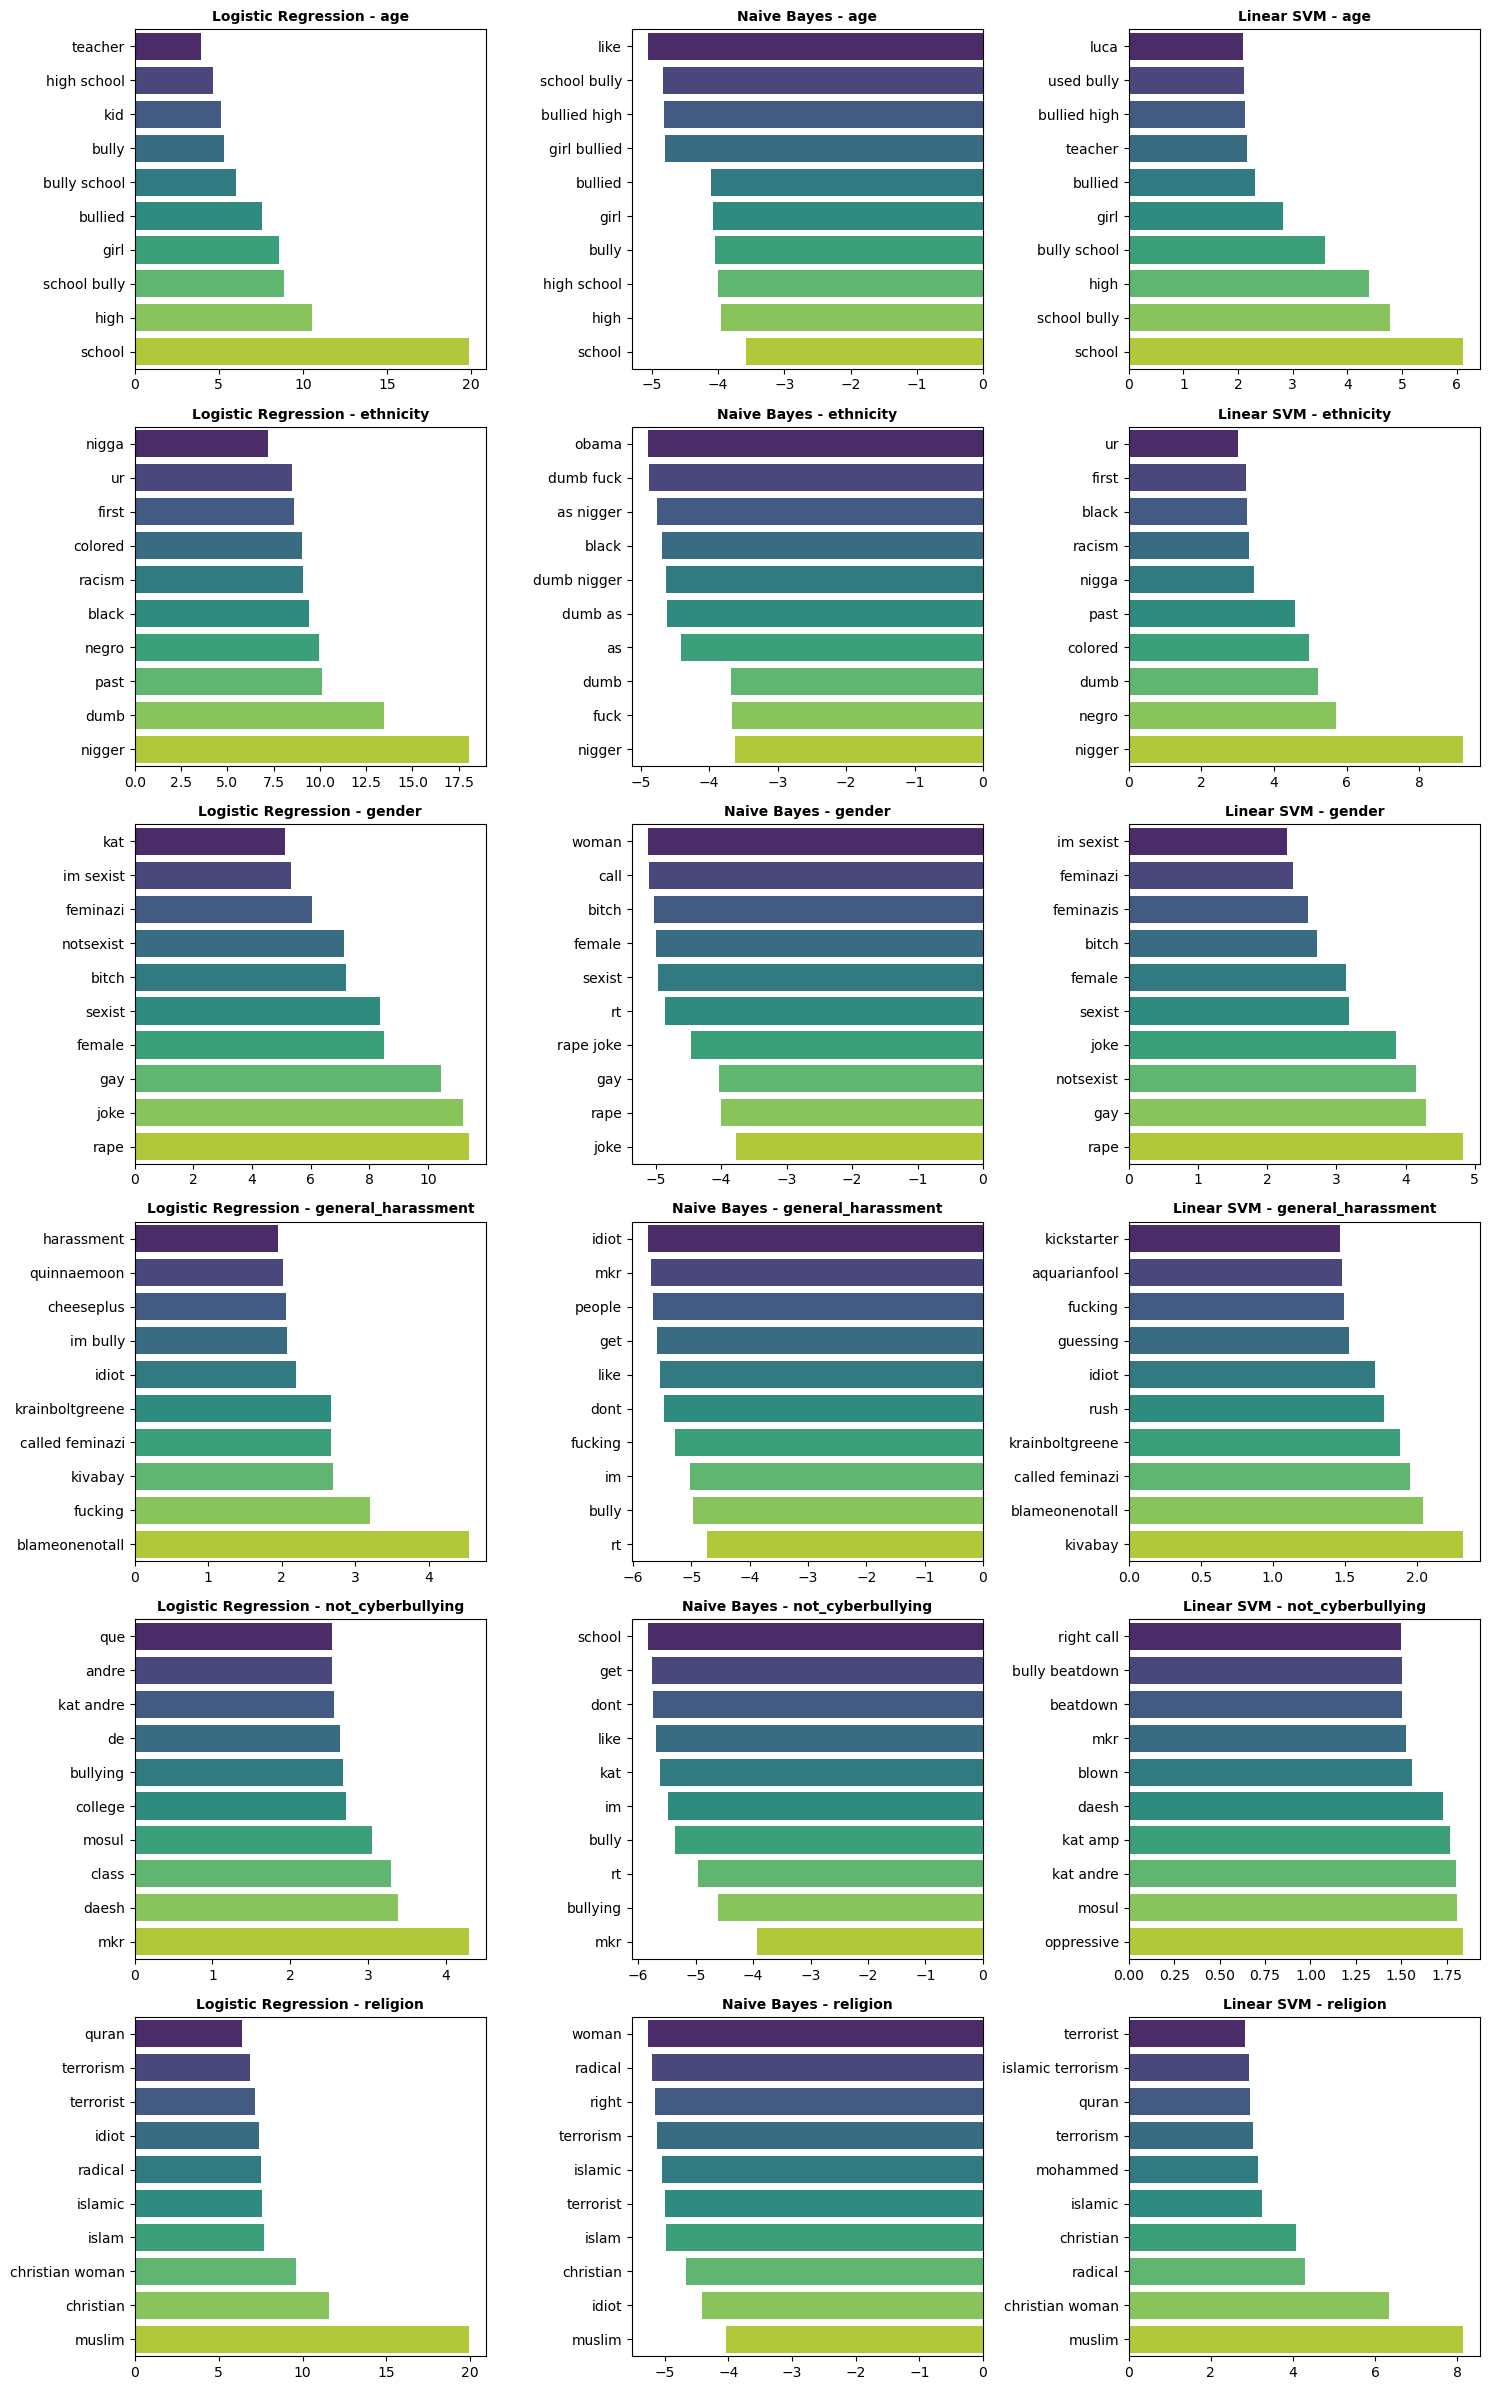

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dictionary of models
models = {
    "Logistic Regression": log_reg,
    "Naive Bayes": nb_model,
    "Linear SVM": svm_model
}

# Get class labels
classes = log_reg.classes_

# TF-IDF feature names
feature_names = tfidf.get_feature_names_out()

# Plot grid dimensions
rows = len(classes)
cols = len(models)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

# Loop through classes and models
for i, class_label in enumerate(classes):
    for j, (model_name, model) in enumerate(models.items()):
        ax = axes[i, j]
        
        # Top words extraction
        if hasattr(model, "coef_"):  # LogReg & SVM
            coefs = model.coef_[i]
            top_idx = np.argsort(coefs)[-10:]  # top 10 words
            top_features = feature_names[top_idx]
            top_vals = coefs[top_idx]
        elif hasattr(model, "feature_log_prob_"):  # NB
            top_idx = model.feature_log_prob_[i].argsort()[-10:]
            top_features = feature_names[top_idx]
            top_vals = model.feature_log_prob_[i][top_idx]
        
        # Barplot
        sns.barplot(x=top_vals, y=top_features, ax=ax, palette="viridis")
        ax.set_title(f"{model_name} - {class_label}", fontsize=10, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("")

plt.tight_layout()
plt.show()


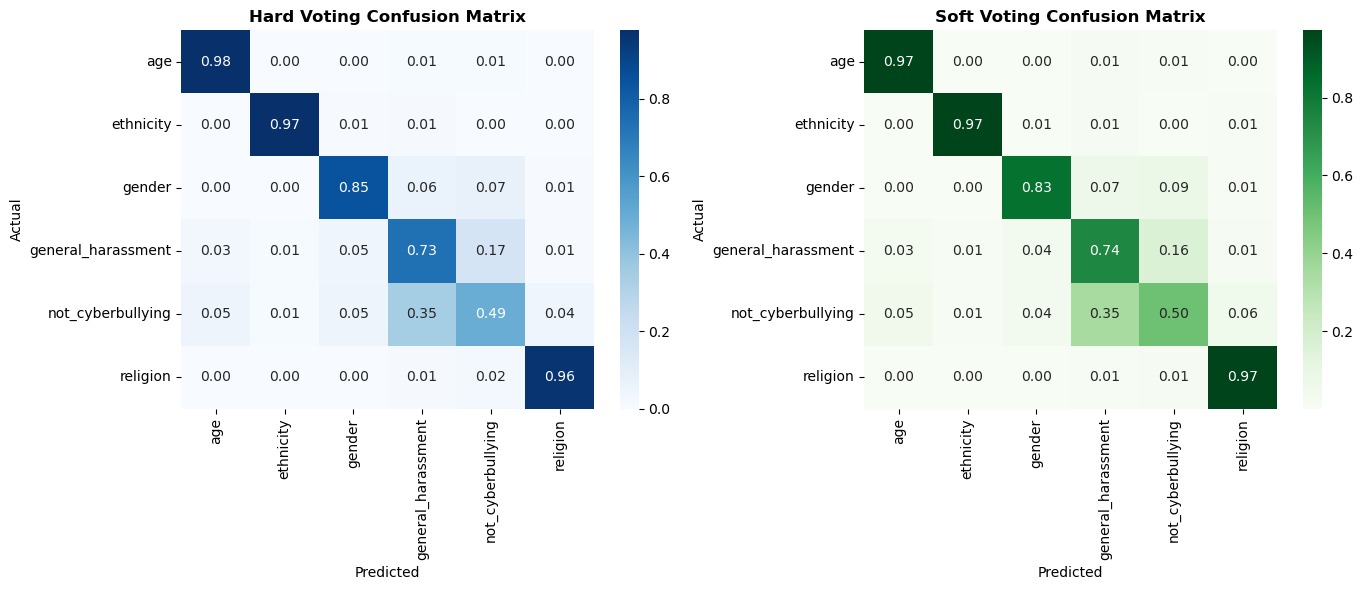

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion for Hard Voting
from sklearn.metrics import confusion_matrix

cm_hard = confusion_matrix(y_test, y_pred_hard, labels=log_reg.classes_)
cm_soft = confusion_matrix(y_test, y_pred_soft, labels=log_reg.classes_)

# Normalize for better comparison
cm_hard_norm = cm_hard.astype('float') / cm_hard.sum(axis=1)[:, np.newaxis]
cm_soft_norm = cm_soft.astype('float') / cm_soft.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(cm_hard_norm, annot=True, fmt=".2f", xticklabels=log_reg.classes_, yticklabels=log_reg.classes_, cmap="Blues", ax=axes[0])
axes[0].set_title("Hard Voting Confusion Matrix", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_soft_norm, annot=True, fmt=".2f", xticklabels=log_reg.classes_, yticklabels=log_reg.classes_, cmap="Greens", ax=axes[1])
axes[1].set_title("Soft Voting Confusion Matrix", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

### Misclassified Examples for All Models (Error Analysis)

In [85]:
#creation of a function to generate misclassified dataframe
def misclassified_df(X_texts, y_true, y_pred, model_name):
    """
    Returns a dataframe of misclassified examples
    """
    df_errors = pd.DataFrame({
        "text": X_texts,
        "true_label": y_true,
        "predicted_label": y_pred
    })
    df_errors = df_errors[df_errors['true_label'] != df_errors['predicted_label']]
    df_errors['model'] = model_name
    return df_errors

# Misclassified examples per model
mis_lr = misclassified_df(X_test_text.values, y_test.values, y_pred, "Logistic Regression")
mis_nb = misclassified_df(X_test_text.values, y_test.values, y_pred_nb, "Naive Bayes")
mis_svm = misclassified_df(X_test_text.values, y_test.values, y_pred_svm, "Linear SVM")
mis_hard = misclassified_df(X_test_text.values, y_test.values, y_pred_hard, "Hard Voting")
mis_soft = misclassified_df(X_test_text.values, y_test.values, y_pred_soft, "Soft Voting")

# Combine all
mis_all = pd.concat([mis_lr, mis_nb, mis_svm, mis_hard, mis_soft], ignore_index=True)

# 5 examples per model
mis_all.groupby('model').apply(lambda x: x.sample(5))

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_9280\3900896681.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mis_all.groupby('model').apply(lambda x: x.sample(5))


text  \
model                                                                         
Hard Voting         6406  btw wadhwa pretty sure im dealing press lately...   
                    6840  im still wrestling wanting get gta v something...   
                    5878  tarah girlziplocked hypatiadotca justkellyok a...   
                    5852  holy crap biggest assclown mayor tuckercarlson...   
                    6607  westernreviews hannabard seen one im sure impl...   
Linear SVM          5240                                       cutie tl lol   
                    4911                                        guild right   
                    4525                             islamlibya whats wrong   
                    4990  verywhiteguy twitter search unless looking blo...   
                    5177  time someone started petition remove healer v ...   
Logistic Regression 1350  rt deray see thats get thinking ever safe lite...   
                    1361                                       leg hit flex   
                    516              piecesofme lol naw lookin tl an seen b   
                    44                onoislam winston churchill said islam   
                    1055  loveconcursall ottomanland time admiring ottom...   
Naive Bayes         2272    think woman dont human right doesntmakemesexist   
                    2123  rt polotek year ago silicon valley lawyer ed z...   
                    1760  bardofpeace difficult sometimes always well re...   
                    2641                                  bully wavyjackson   
                    3241  rt mczub freebsdgirl feel like new people clai...   
Soft Voting         7259                                                mkr   
                    7638           rt reuters islamic state say u run idiot   
                    7373  athenahollow would im hoping personal attack t...   
                    7168              rt citgo nb yo bad couch folded nigga   
                    7693  elephant show arent comin ya celine justsayin mkr   

                                  true_label     predicted_label  \
model                                                              
Hard Voting         6406   not_cyberbullying  general_harassment   
                    6840   not_cyberbullying  general_harassment   
                    5878   not_cyberbullying  general_harassment   
                    5852           ethnicity  general_harassment   
                    6607   not_cyberbullying  general_harassment   
Linear SVM          5240   not_cyberbullying  general_harassment   
                    4911  general_harassment   not_cyberbullying   
                    4525   not_cyberbullying  general_harassment   
                    4990   not_cyberbullying  general_harassment   
                    5177   not_cyberbullying  general_harassment   
Logistic Regression 1350   not_cyberbullying  general_harassment   
                    1361   not_cyberbullying  general_harassment   
                    516    not_cyberbullying  general_harassment   
                    44     not_cyberbullying            religion   
                    1055            religion   not_cyberbullying   
Naive Bayes         2272              gender            religion   
                    2123              gender  general_harassment   
                    1760   not_cyberbullying  general_harassment   
                    2641  general_harassment                 age   
                    3241  general_harassment   not_cyberbullying   
Soft Voting         7259              gender   not_cyberbullying   
                    7638  general_harassment            religion   
                    7373  general_harassment   not_cyberbullying   
                    7168  general_harassment           ethnicity   
                    7693              gender   not_cyberbullying   

                                        model  
model                                          
Hard